## Importing files

In [144]:
# Importing requiered libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import ast
import utils.helpers

# Reload the functions module
importlib.reload(utils.helpers)

<module 'utils.helpers' from 's:\\Courses\\Data Science\\0. Henry\\M7 - Labs - Project MLOps\\recommendation-system-movies-similarity-and-rating\\EDA\\utils\\helpers.py'>

In [145]:
# Importing eda_movies_data.csv file
dataset_path = "data\eda_movies_data.csv"

# Setting low_memory=False - To read the entire file so it determines the data types accurately. 
# Note: It can increase memory usage for larger datasets
info_movies = pd.read_csv(dataset_path, low_memory=False)

In [146]:
info_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45346 entries, 0 to 45345
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 45346 non-null  int64  
 1   title              45346 non-null  object 
 2   collection_name    4485 non-null   object 
 3   movie_genres       45346 non-null  object 
 4   release_year       45346 non-null  int64  
 5   status             45266 non-null  object 
 6   return             45346 non-null  float64
 7   revenue            45346 non-null  float64
 8   budget             45346 non-null  int64  
 9   vote_count         45346 non-null  float64
 10  vote_average       45346 non-null  float64
 11  popularity         45346 non-null  float64
 12  original_language  45335 non-null  object 
 13  overview           44405 non-null  object 
 14  companies_name     45346 non-null  object 
 15  prod_countries     45346 non-null  object 
 16  runtime            451

## Data Preparation

### Data cleaning

#### Check movies that have empty date values

In [147]:
# Creating a copy of the information
data_for_analysis = info_movies.copy()
# Checking the data type
utils.helpers.get_column_summary(data_for_analysis, "release_year")

(release_year
 <class 'int'>    45346
 Name: count, dtype: int64,
 'total values:',
 45346)

In [148]:
# Checking the number of values that have a 0 value in year 
count = 0
for year in data_for_analysis["release_year"]:
    if year == 0:
        count += 1
print(count)

0


#### Delete movies that aren't released yet

In [149]:
# Checking movies that aren't released yet
not_released = []
for idx, (status_value, id_movie) in enumerate(zip(data_for_analysis["status"], data_for_analysis["id"])):
    if status_value != "Released":
        not_released.append(id_movie)

print(len(not_released))

439


In [150]:
# Having only 439 values without status, and bieng less than 1% of the total values
# Deleting the values from the dataset
data_for_analysis_1 = data_for_analysis.copy()

for idx, id_movie_value in enumerate(data_for_analysis_1["id"]):
    if id_movie_value in not_released:
        data_for_analysis_1.drop(idx, inplace=True)


In [151]:
data_for_analysis_1.drop("status", axis=1, inplace=True)


In [152]:
data_for_analysis_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44907 entries, 0 to 45345
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 44907 non-null  int64  
 1   title              44907 non-null  object 
 2   collection_name    4463 non-null   object 
 3   movie_genres       44907 non-null  object 
 4   release_year       44907 non-null  int64  
 5   return             44907 non-null  float64
 6   revenue            44907 non-null  float64
 7   budget             44907 non-null  int64  
 8   vote_count         44907 non-null  float64
 9   vote_average       44907 non-null  float64
 10  popularity         44907 non-null  float64
 11  original_language  44897 non-null  object 
 12  overview           44000 non-null  object 
 13  companies_name     44907 non-null  object 
 14  prod_countries     44907 non-null  object 
 15  runtime            44667 non-null  float64
 16  sp_languages       44907 no

#### Delete movies without votes

In [153]:
# Deleting values with 0 vote count and 0 vote average
# That will mean that it didn't have any entry data

temp_dataset = data_for_analysis_1.copy()
temp_dataset.loc[:, "to_delete"] = np.nan  # Use .loc to assign NaN values to the column

for idx, (votes, rating) in enumerate(zip(temp_dataset["vote_count"], temp_dataset["vote_average"])):
    if votes == 0 and rating == 0:
        temp_dataset.at[idx, "to_delete"] = 1

data_for_analysis_2 = temp_dataset[temp_dataset['to_delete'] != 1]
data_for_analysis_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42153 entries, 0 to 45345
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 42153 non-null  float64
 1   title              42153 non-null  object 
 2   collection_name    4207 non-null   object 
 3   movie_genres       42153 non-null  object 
 4   release_year       42153 non-null  float64
 5   return             42153 non-null  float64
 6   revenue            42153 non-null  float64
 7   budget             42153 non-null  float64
 8   vote_count         42153 non-null  float64
 9   vote_average       42153 non-null  float64
 10  popularity         42153 non-null  float64
 11  original_language  42143 non-null  object 
 12  overview           41332 non-null  object 
 13  companies_name     42153 non-null  object 
 14  prod_countries     42153 non-null  object 
 15  runtime            41939 non-null  float64
 16  sp_languages       42153 no

### Extract information for ML model

#### Collection

In [154]:
movie_collection = data_for_analysis_1[["id", "title", "collection_name"]].copy()

movie_collection = movie_collection.dropna(subset=["collection_name"])


In [ ]:
# Save the selected DataFrame to a CSV file
movie_collection.to_csv('../ML_model/data/collections.csv', index=False)

#### Genre

In [96]:
movie_genre = data_for_analysis_1[["id", "title", "movie_genres"]].copy()

In [97]:
movie_genre.shape[0]

44907

In [126]:
idx_list = []
for idx, list in enumerate(movie_genre['movie_genres']):
    list_genre = ast.literal_eval(list)
    if len(list_genre) > 0:
        idx_list.append(idx)
#movie_genre_1 = movie_genre[ast.literal_eval(movie_genre['movie_genres']).apply(lambda x: len(x) > 0)]

In [127]:
movie_genre_1 = movie_genre[~movie_genre["id"].isin(idx_list)]

In [135]:
# Save the selected DataFrame to a CSV file
movie_genre_1.to_csv('../ML_model/data/genre.csv', index=False)

#### Overview

In [156]:
movie_overview = data_for_analysis_1[["id", "title", "overview"]].copy()

In [158]:
# Save the selected DataFrame to a CSV file
movie_overview.to_csv('../ML_model/data/overview.csv', index=False)

## Data Analysis

### Distribution of movies by genre

In [19]:
# List of all the genres
all_genres = []
for list in data_for_analysis_1["movie_genres"]:
    genre_list = ast.literal_eval(list)
    for genre in genre_list:
        all_genres.append(genre)
#len(all_genres)

90208

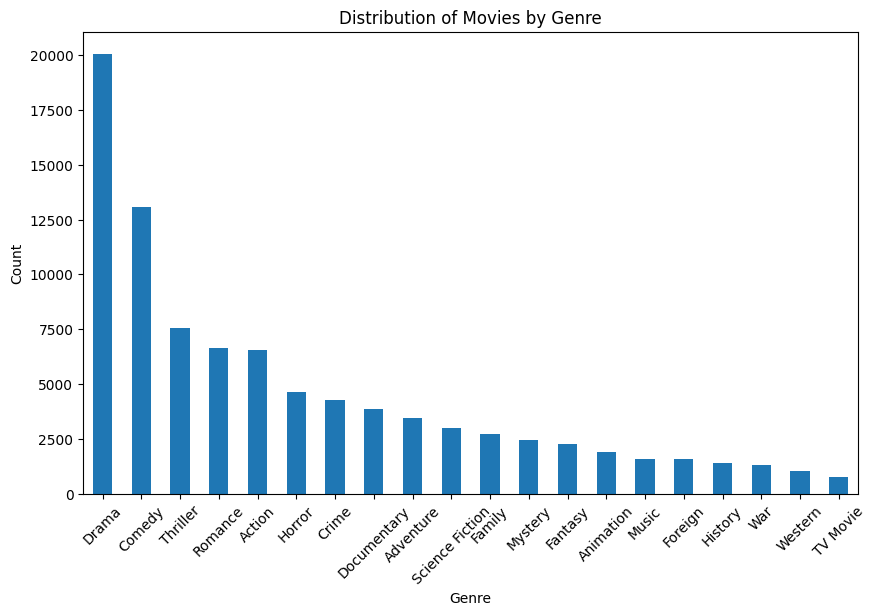

In [20]:
# Count the occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Distribution of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### "vote count" data

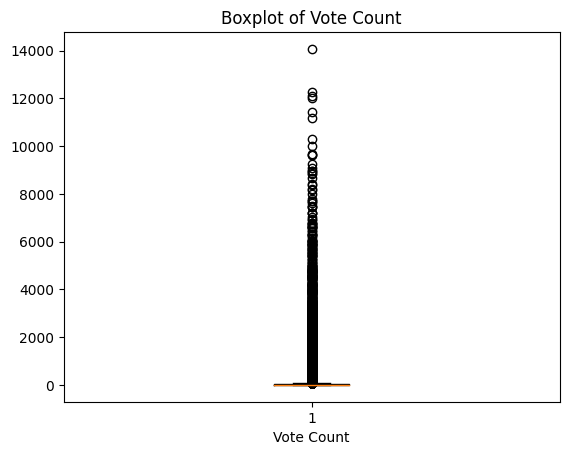

In [ ]:
# Create a boxplot to visualize the distribution and identify outliers
plt.boxplot(data_for_analysis_2['vote_count'])
plt.title('Boxplot of Vote Count')
plt.xlabel('Vote Count')
plt.show()

In [ ]:
# Calculate summary statistics
vcount_summary = data_for_analysis_2['vote_count'].describe()

# Print the summary statistics
print(vcount_summary)

# Extract individual statistics
outl_mean = vcount_summary['mean']
outl_median = vcount_summary['50%']  # Median
outl_std_dev = vcount_summary['std']
outl_minimum = vcount_summary['min']
outl_maximum = vcount_summary['max']
outl_q1 = vcount_summary['25%']  # First quartile
outl_q3 = vcount_summary['75%']  # Third quartile

# Analyze the range of values
outl_range_values = outl_maximum - outl_minimum

count    42153.000000
mean       112.793063
std        497.708918
min          0.000000
25%          3.000000
50%         10.000000
75%         36.000000
max      14075.000000
Name: vote_count, dtype: float64


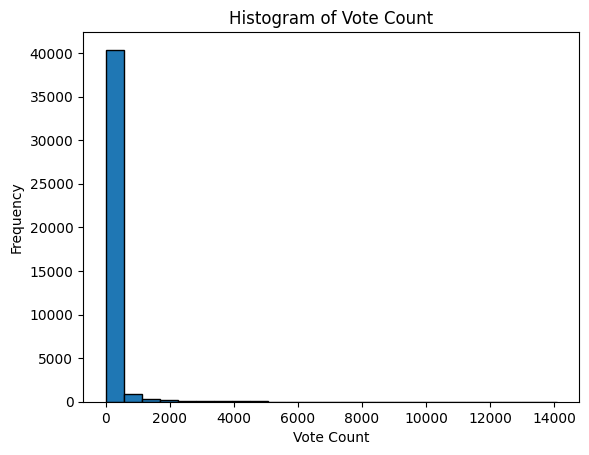

In [69]:
# Plotting the histogram
plt.hist(data_for_analysis_2['vote_count'], bins=25, edgecolor='black')

# Adding labels and title
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.title('Histogram of Vote Count')

# Displaying the histogram
plt.show()

In [70]:
# Calculate the IQR
Q1_vcount = np.percentile(data_for_analysis_2['vote_count'], 25)
Q3_vcount = np.percentile(data_for_analysis_2['vote_count'], 75)
IQR_vcount = Q3_vcount - Q1_vcount

# Define the lower and upper bounds
lower_bound_vcount = Q1_vcount - 1.5 * IQR_vcount
upper_bound_vcount = Q3_vcount + 1.5 * IQR_vcount

# Exclude outliers by filtering the dataset
filtered_data_vcount = data_for_analysis_2[(data_for_analysis_2['vote_count'] >= lower_bound_vcount) & (data_for_analysis_2['vote_count'] <= upper_bound_vcount)]

# Calculate the statistical summary for the filtered dataset
vcount_summary_2 = filtered_data_vcount['vote_count'].describe()
vcount_summary_2

count    35802.000000
mean        14.374197
std         17.582658
min          0.000000
25%          3.000000
50%          7.000000
75%         19.000000
max         85.000000
Name: vote_count, dtype: float64

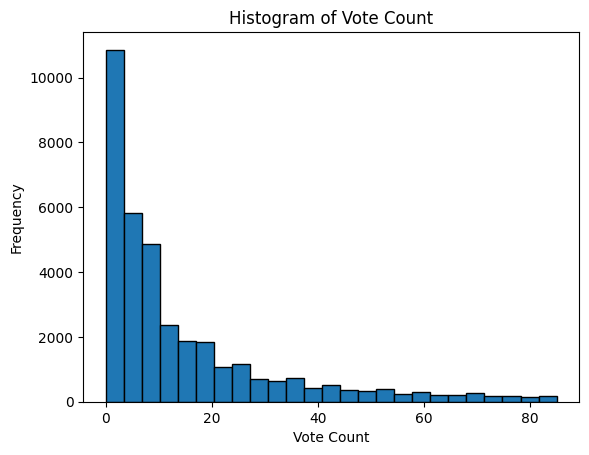

In [72]:
# Plotting the histogram
plt.hist(filtered_data_vcount['vote_count'], bins=25, edgecolor='black')

# Adding labels and title
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.title('Histogram of Vote Count')

# Displaying the histogram
plt.show()

The majority of movies receive a relatively low number of votes, with the median being 7. There is a significant variation in the number of votes received, as indicated by the relatively high standard deviation

### Popularity and vote count

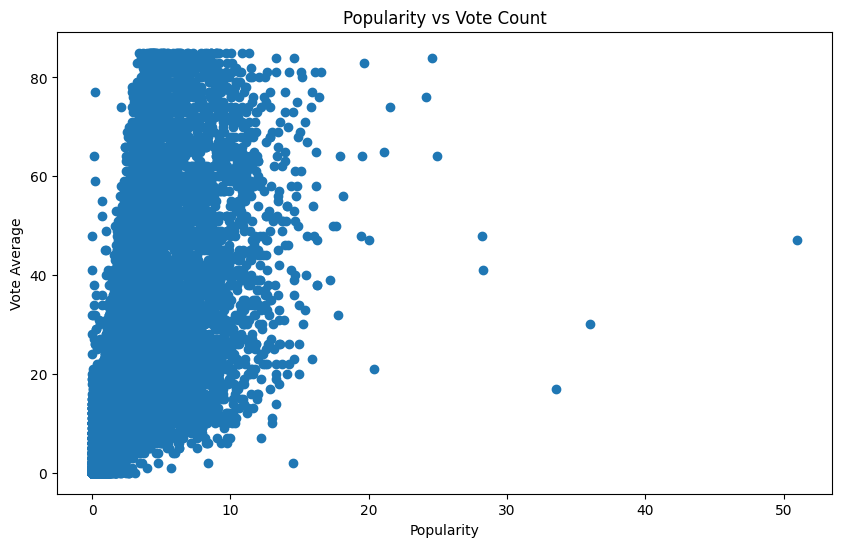

In [87]:
# Plotting the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.scatter(filtered_data_vcount['popularity'], filtered_data_vcount['vote_count'])
plt.title('Popularity vs Vote Count')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.show()


### "vote average" column

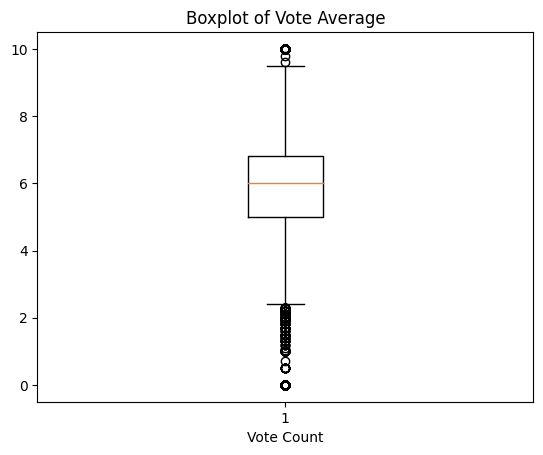

In [ ]:
# Create a boxplot to visualize the distribution and identify outliers
plt.boxplot(data_for_analysis_2['vote_average'])
plt.title('Boxplot of Vote Average')
plt.xlabel('Vote Count')
plt.show()

In [73]:
# Calculate summary statistics
vavg_summary = data_for_analysis_2['vote_average'].describe()

# Print the summary statistics
print(vavg_summary)

# Extract individual statistics
outl_mean = vavg_summary['mean']
outl_median = vavg_summary['50%']  # Median
outl_std_dev = vavg_summary['std']
outl_minimum = vavg_summary['min']
outl_maximum = vavg_summary['max']
outl_q1 = vavg_summary['25%']  # First quartile
outl_q3 = vavg_summary['75%']  # Third quartile

# Analyze the range of values
outl_range_values = outl_maximum - outl_minimum

count    42153.000000
mean         5.642896
std          1.892036
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64


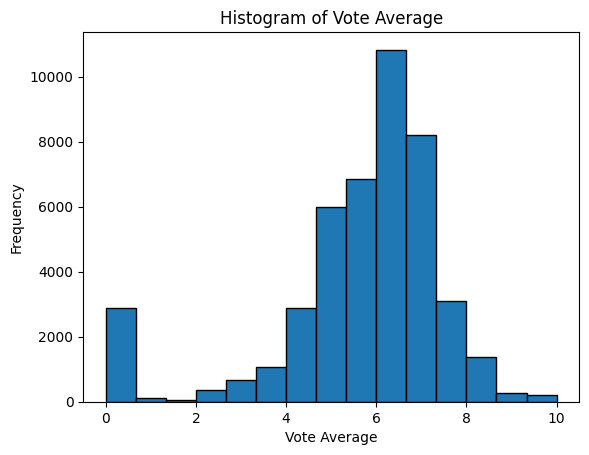

In [ ]:
# Plotting the histogram
plt.hist(data_for_analysis_2['vote_average'], bins=15, edgecolor='black')

# Adding labels and title
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.title('Histogram of Vote Average')

# Displaying the histogram
plt.show()

In [74]:
# Calculate the IQR
Q1_vavg = np.percentile(data_for_analysis_2['vote_average'], 25)
Q3_vavg = np.percentile(data_for_analysis_2['vote_average'], 75)
IQR_vavg = Q3_vavg - Q1_vavg

# Define the lower and upper bounds
lower_bound = Q1_vavg - 1.5 * IQR_vavg
upper_bound = Q3_vavg + 1.5 * IQR_vavg

# Exclude outliers by filtering the dataset
filtered_data_vavg = data_for_analysis_2[(data_for_analysis_2['vote_average'] >= lower_bound) & (data_for_analysis_2['vote_average'] <= upper_bound)]

# Calculate the statistical summary for the filtered dataset
filtered_summary_vavg = filtered_data_vavg['vote_average'].describe()
filtered_summary_vavg

count    38985.000000
mean         6.041654
std          1.151294
min          2.400000
25%          5.300000
50%          6.100000
75%          6.800000
max          9.500000
Name: vote_average, dtype: float64

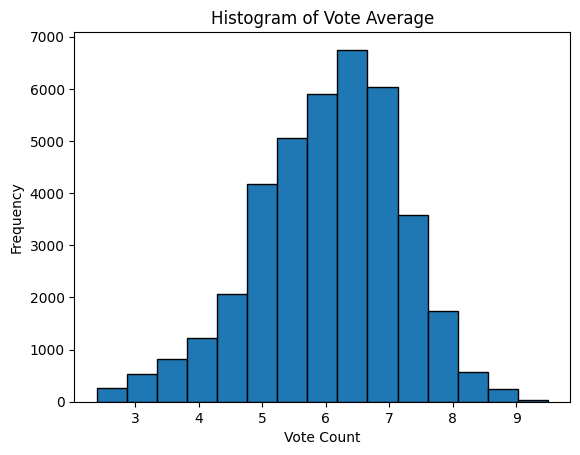

In [75]:
# Plotting the histogram
plt.hist(filtered_data_vavg['vote_average'], bins=15, edgecolor='black')

# Adding labels and title
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.title('Histogram of Vote Average')

# Displaying the histogram
plt.show()

### Popularity and vote average

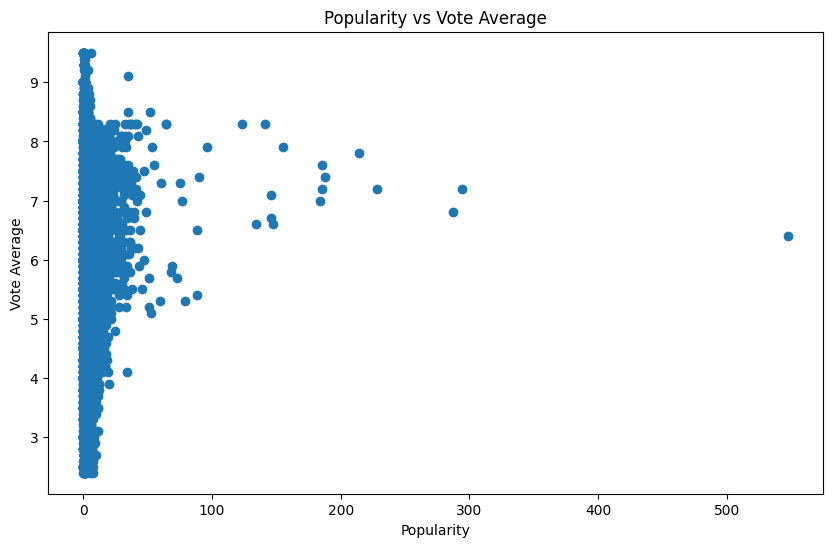

In [76]:
# Plotting the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.scatter(filtered_data_vavg['popularity'], filtered_data_vavg['vote_average'])
plt.title('Popularity vs Vote Average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.show()


### "return" column

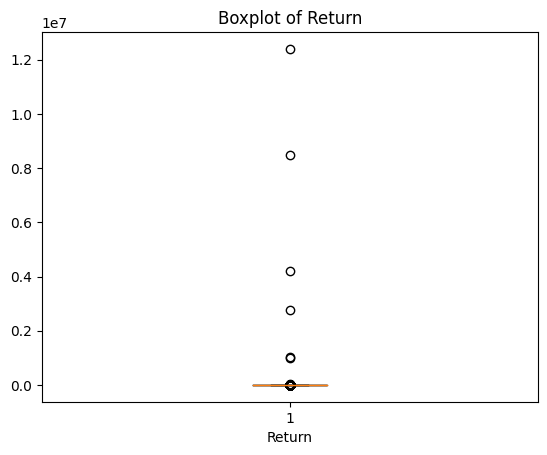

In [80]:
# Create a boxplot to visualize the distribution and identify outliers
plt.boxplot(data_for_analysis_1['return'])
plt.title('Boxplot of Return')
plt.xlabel('Return')
plt.show()